# Describe

Describe and visualizes dataset statistics

### Set-up

In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import matplotlib.pyplot as plt
import mlrun
import os

In [2]:
mlrun.set_environment(project = "function-marketplace")
context = mlrun.get_or_create_ctx("function-marketplace")

> 2021-08-15 12:18:54,262 [info] logging run results to: http://mlrun-api:8080


### Loading dataset
We will use boston hose prices dataset from sklearn

In [3]:
boston_dataset = load_boston()

In [4]:
print(boston_dataset["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [5]:
boston_df = pd.DataFrame(data = boston_dataset["data"],columns = boston_dataset["feature_names"])
boston_df["TARGET"] = boston_dataset["target"]
# taking first 100 rows - so calculating all the histograms will be fast.
boston_df = boston_df[:100]
os.mkdir('artifacts')
boston_df.to_parquet("artifacts/boston_housing.parquet")

### Importing and running the function

In [6]:
describe = mlrun.import_function("hub://describe").apply(mlrun.auto_mount())

In [7]:
describe_task = mlrun.new_task(name = 'describe_boston',
                               params = {'key' : 'summary',
                                         'label_column' : 'TARGET',
                                         'plot_hist' : True,
                                         'plot_dest' : os.getcwd()},
                               inputs = {"table" : "artifacts/boston_housing.parquet"},
                               
                               artifact_path = os.getcwd()+'/artifacts',
                               in_path = os.getcwd())

In [8]:
describe.run(describe_task)

> 2021-08-15 12:18:54,717 [info] starting run describe_boston uid=bb7db582f18a4d5191d6e0d0f87bcd3b DB=http://mlrun-api:8080
> 2021-08-15 12:18:54,826 [info] Job is running in the background, pod: describe-boston-b6pfl
> 2021-08-15 12:20:01,530 [info] run executed, status=completed
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
function-marketplace,...f87bcd3b,0,Aug 15 12:19:01,completed,describe_boston,v3io_user=danikind=jobowner=danihost=describe-boston-b6pfl,table,key=summarylabel_column=TARGETplot_hist=Trueplot_dest=/User/test/functions/describe,,histogramsviolinimbalanceimbalance-weights-veccorrelation-matrixcorrelation


to track results use .show() or .logs() or in CLI: 
!mlrun get run bb7db582f18a4d5191d6e0d0f87bcd3b --project function-marketplace , !mlrun logs bb7db582f18a4d5191d6e0d0f87bcd3b --project function-marketplace
> 2021-08-15 12:20:04,242 [info] run executed, status=completed


### Plotting results

In [9]:
from IPython.display import IFrame

In [10]:
IFrame("artifacts/plots/violin.html", width=1300, height=600)

In [11]:
from seaborn import heatmap

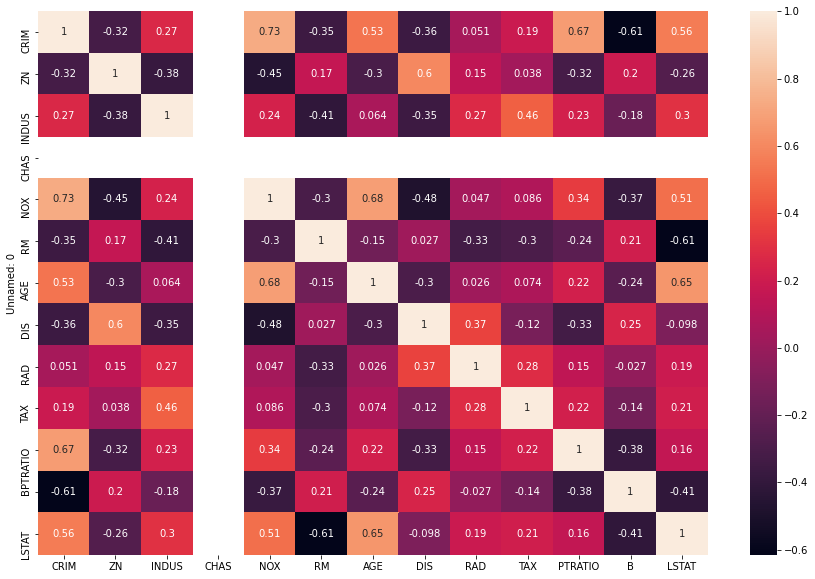

In [12]:
plt.figure(figsize = (15,10))
my_heatmap = pd.read_csv("artifacts/plots/correlation-matrix.csv").set_index("Unnamed: 0")
heatmap(my_heatmap,annot=True)